In [2]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

In [3]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

In [4]:
import albumentations as A

agumentation guide: https://github.com/albumentations-team/albumentations#spatial-level-transforms

Follow this: https://pseudo-lab.github.io/Tutorial-Book-en/chapters/en/object-detection/Ch3-preprocessing.html

In [5]:
# CUDA
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# helper function for dataset
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

In [7]:
def generate_label(obj):
    # only have ships
    return 0 

In [8]:
def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "xml")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))


        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}

        
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target


In [35]:
def plot_image_from_output(img, annotation):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [9]:
list(sorted(os.listdir("annotations_yolo/")))[0][:-3]

'01_10_12.'

In [58]:
class ShipDataset:
    def __init__(self, path, transform=None):
        self.path = path
        self.files = list(sorted(os.listdir("annotations_yolo/")))
        self.transform = transform
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_image = self.files[idx][:-3] + 'jpg'
        file_label = self.files[idx][:-3] + 'xml'

        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        
        #print(img_path)
        # Read an image with OpenCV, gray scale
        image = cv2.imread(img_path,0)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image/255.0
        target = generate_target(label_path)

        #start_t = time.time()
        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
        
        image = torch.tensor(image,dtype=torch.float32)
        
        image = torch.unsqueeze(image, dim=0)
            
        return image, target #, total_time

In [59]:
# TODO: Include transformations/albumnations for dataset
# resize to 640, include mirror images, as well as gaussian noise 

In [60]:
# Albumenation augmentation ideas
# RandomBrightnessContrast
# GaussNoise

In [138]:
# Declare an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.GaussianBlur(p=1),
    A.GaussNoise(p=1,var_limit=(0,1))
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=[]))

In [ ]:
transform = A.Compose([
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])

In [139]:
dataset = ShipDataset(
    path = 'images/',
    transform=transform
)
len(dataset)

1859

In [140]:
img, annotation = dataset[0]

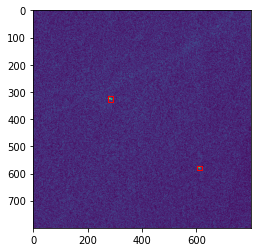

In [141]:
plot_image_from_output(img, annotation)

In [15]:
train_set, val_set = torch.utils.data.random_split(dataset, [1400,459])
len(train_set), len(val_set)

(1400, 459)

In [29]:
train_set

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4,collate_fn=collate_fn)

In [24]:
train_loader

In [25]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 1, weights=False, pretrained_backbone = True)


/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
num_epochs = 1
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
optimizer = torch.optim.SGD(params, lr=0.0001,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_loader)

# about 4 min per epoch on Colab GPU
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        
        #print(targets)
        

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print(images)
        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

TypeError: image must be numpy array type

In [17]:
# getting a Nan value for loss, possible causes:
#   Gradients exploding, use gradient clipping
#   Data is not normalized, reduce values of data

In [ ]:
#evaluate(retina, val_set, device=device)

In [50]:
totalValLoss = 0
# switch off autograd
with torch.no_grad():
		# set the model in evaluation mode
	retina.eval()
		# loop over the validation set
	for (images, labelNbox) in val_set:
		# send the input to the device
		(images, labels, bboxes) = (images.to(device),
			labelNbox["labels"].to(device), labelNbox["boxes"].to(device))
			# make the predictions and calculate the validation loss
		#print(images.shape)
		images = images.reshape(1,800,800)
		# need to add extra dimension for batch
		images = torch.unsqueeze(images, dim=0)
		#print(images.shape)
		predictions = retina(images)
		print(predictions)
		totalLoss = sum(loss for loss in predictions.values()) 
		totalValLoss += totalLoss
			# calculate the number of correct predictions
		#valCorrect += (predictions[1].argmax(1) == labels).type(
				#torch.float).sum().item()

[{'boxes': tensor([[495.0399,  17.6567, 526.0787,  46.3136],
        [585.3160, 714.2757, 599.2332, 728.5322],
        [590.5747, 714.9469, 604.8293, 729.7625],
        ...,
        [602.5636, 443.1787, 609.7017, 450.4985],
        [640.9027, 434.4478, 648.6368, 442.0447],
        [603.6652, 415.1117, 612.5547, 423.9015]], device='cuda:0'), 'scores': tensor([0.4465, 0.4411, 0.3999, 0.3985, 0.3944, 0.3799, 0.3465, 0.3045, 0.2831,
        0.2739, 0.2738, 0.2709, 0.2619, 0.2520, 0.2362, 0.2349, 0.2327, 0.2300,
        0.2136, 0.2117, 0.2072, 0.2062, 0.2041, 0.2038, 0.2011, 0.2009, 0.2001,
        0.1989, 0.1988, 0.1940, 0.1920, 0.1868, 0.1867, 0.1836, 0.1803, 0.1799,
        0.1769, 0.1768, 0.1746, 0.1744, 0.1733, 0.1720, 0.1714, 0.1706, 0.1671,
        0.1654, 0.1643, 0.1622, 0.1602, 0.1582, 0.1574, 0.1557, 0.1548, 0.1544,
        0.1541, 0.1540, 0.1527, 0.1452, 0.1430, 0.1428, 0.1421, 0.1421, 0.1413,
        0.1411, 0.1398, 0.1378, 0.1370, 0.1364, 0.1347, 0.1347, 0.1339, 0.1323,
       

AttributeError: 'list' object has no attribute 'values'

In [57]:
len(predictions[0]["scores"])

300